In [102]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster



In [103]:
# Define the Dow Jones Index stock symbols excluding 'FB'
dow_symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "TSLA", "BABA", "TSM", "V", 
               "JPM", "JNJ", "NVDA", "PYPL", "HD", "ASML", "DIS", "CMCSA", "BAC", "NFLX",
               "WMT", "CSCO", "PG", "INTC", "VZ", "T", "ADBE", "KO", "PEP", "TMUS", "ORCL"]

# Download historical data
data = yf.download(dow_symbols, start="2022-01-01", end="2023-01-01")[['Adj Close']]


data.columns = data.columns.droplevel(0)



[*********************100%%**********************]  30 of 30 completed


In [95]:
# data.to_csv('yahoofinance_data.csv', index=True)


In [104]:

# Calculate daily returns
returns = data.pct_change().dropna()

# Handle missing and infinite values
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the correlation matrix
correlation_matrix = returns.corr()

# Perform PCA
pca = PCA()
pca.fit(correlation_matrix)

# Get principal components
principal_components = pca.components_



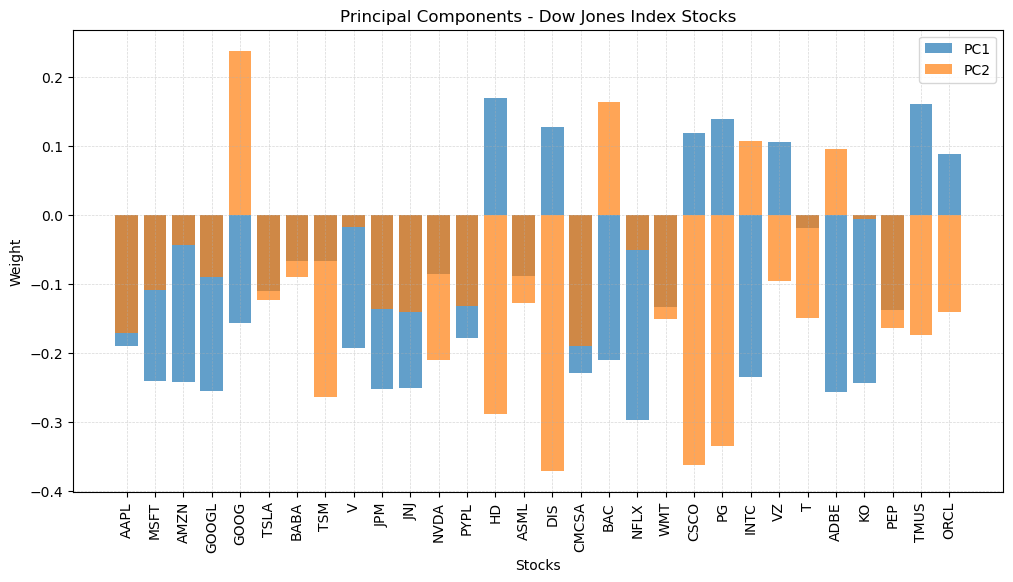

In [105]:

# Plot bar graphs for the first principal component
plt.figure(figsize=(12, 6))
plt.bar(range(len(dow_symbols)), principal_components[0], alpha=0.7, label='PC1')# ax = axes[0])
plt.bar(range(len(dow_symbols)), principal_components[1], alpha=0.7, label='PC2')
plt.xticks(range(len(dow_symbols)), dow_symbols, rotation=90)
plt.title('Principal Components - Dow Jones Index Stocks')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.legend()
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()

# 1.4

Number of principal components to explain 95% of the variance: 12


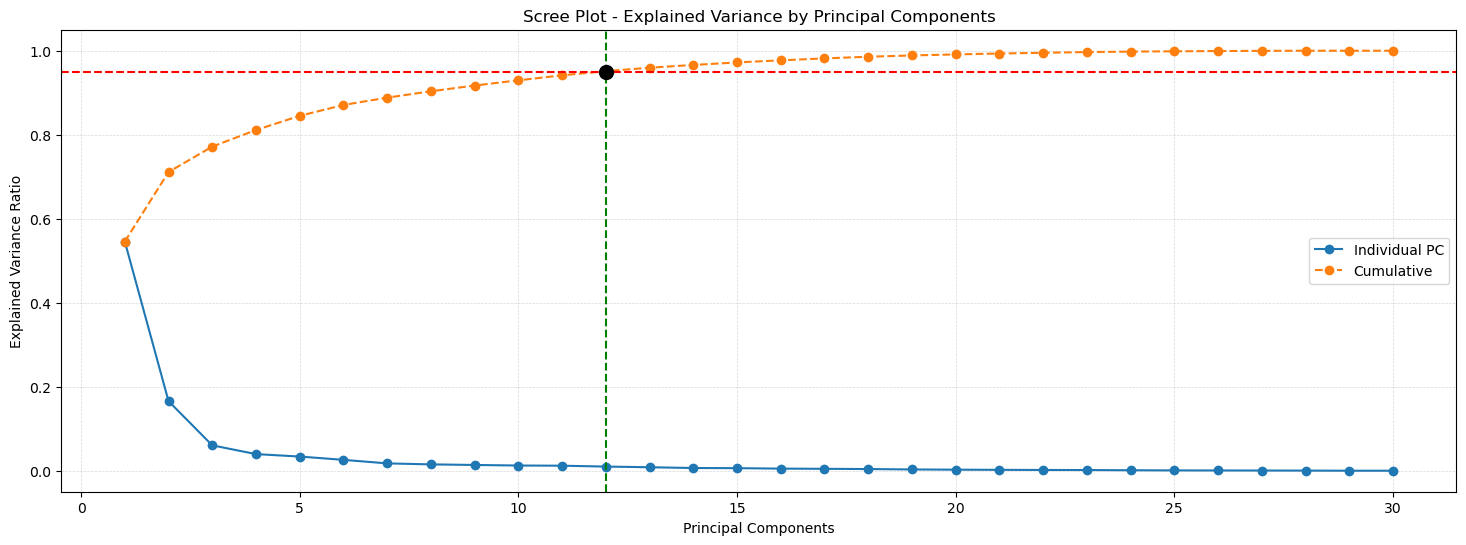

In [98]:
# Get the explained variances
explained_variances = pca.explained_variance_ratio_

# Cumulative sum of explained variances
cumulative_variances = np.cumsum(explained_variances)

# Determine the number of principal components required to explain 95% of the variance
num_components_95_percent = np.argmax(cumulative_variances >= 0.95) + 1
print(f'Number of principal components to explain 95% of the variance: {num_components_95_percent}')

# Plot the 'Scree' plot
plt.figure(figsize=(18, 6))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o', label='Individual PC')
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o', linestyle='--', label='Cumulative')
plt.title('Scree Plot - Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
plt.axvline(x=num_components_95_percent, color='green', linestyle='--', label='Required PC')
plt.plot(num_components_95_percent, 0.95, marker='o', color='black', markersize=10)
plt.show()



# 1.5

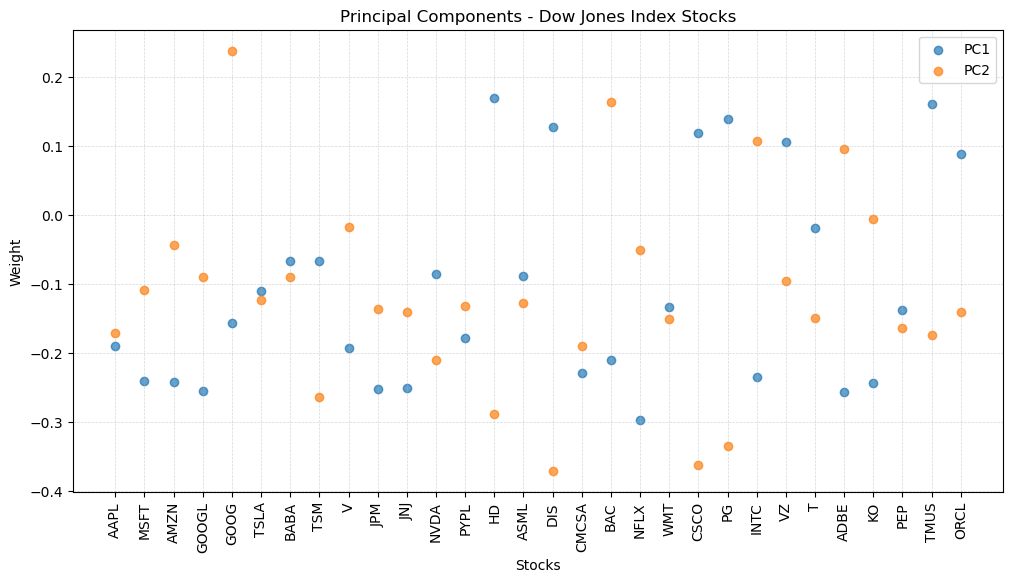

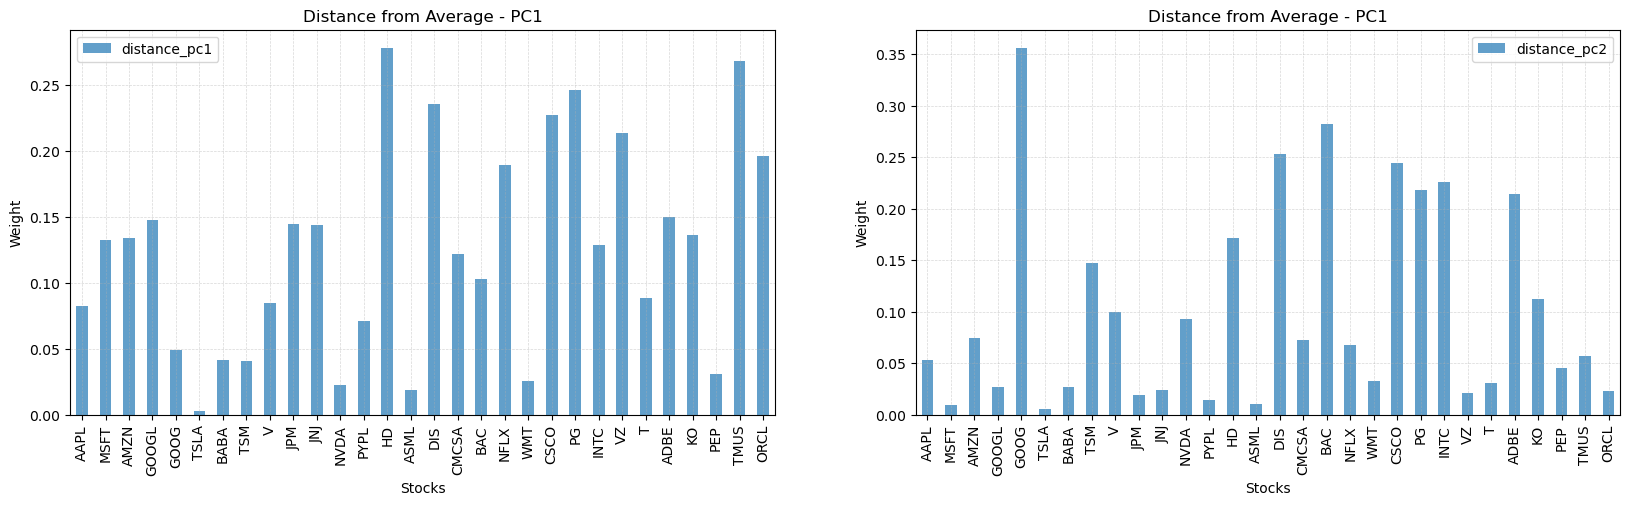

In [126]:
# Plot bar graphs for the first principal component
plt.figure(figsize=(12, 6))
plt.scatter(range(len(dow_symbols)), principal_components[0], alpha=0.7, label='PC1')# ax = axes[0])
plt.scatter(range(len(dow_symbols)), principal_components[1], alpha=0.7, label='PC2')
plt.xticks(range(len(dow_symbols)), dow_symbols, rotation=90)
plt.title('Principal Components - Dow Jones Index Stocks')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.legend()
plt.grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()




# Calculate the distance from each company to the average of the first principal component
distance_pc1 = np.abs(principal_components[0] - pc1_average)
dist1_dataframe = pd.DataFrame(distance_pc1, columns=['distance_pc1'], index=dow_symbols)
# calculate the distance from each company to the average of the second principal component
distance_pc2 = np.abs(principal_components[1] - pca_2_average)
dist2_dataframe = pd.DataFrame(distance_pc2, columns=['distance_pc2'], index=dow_symbols)

# Calculate the average of the first principal component
pc1_average = np.mean(distance_pc1)

# Calculate the average of the second principal component
pca_2_average = np.mean(distance_pc2)
# dist2_dataframe.sort_values(by='distance_pc2', ascending=False, inplace=True)
# dist1_dataframe.sort_values(by='distance_pc1', ascending=False, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot bar graphs for the first principal component
dist1_dataframe.plot(kind='bar', ax=axes[0], alpha=0.7, legend=True, title='Distance from Average - PC1')
axes[0].set_xticks(range(len(dow_symbols)), dow_symbols, rotation=90)

axes[0].set_xlabel('Stocks')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)

# Plot bar graphs for the second principal component
dist2_dataframe.plot(kind='bar', ax=axes[1], alpha=0.7, legend=True, title='Distance from Average - PC1')
axes[1].set_xticks(range(len(dow_symbols)), dow_symbols, rotation=90)

axes[1].set_xlabel('Stocks')
axes[1].set_ylabel('Weight')
axes[1].legend()
axes[1].grid(True, linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

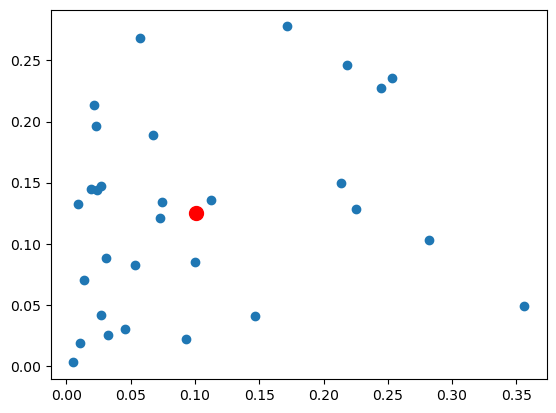

In [136]:
# plt.scatter(dist2_dataframe, distance_pc1)
# plt.plot(pca_2_average, pc1_average,  'ro', markersize=10, label='Average')
# plt.show()

# Assuming you have dist2_dataframe, distance_pc1, pca_2_average, and pc1_average

plt.scatter(dist2_dataframe, distance_pc1)
plt.plot(pca_2_average, pc1_average, 'ro', markersize=10, label='Average')

# Annotate each point with the corresponding index
for i, (x, y) in enumerate(zip(dist2_dataframe)):
    plt.annotate(f'Index {i}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('dist2_dataframe')
plt.ylabel('distance_pc1')
plt.title('Scatter Plot with Annotations')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()


# Exercises 2

## 1.

#### A dendrogram that visualizes a clustering hierarchy is often integrated with a reorderable matrix for pattern identification.

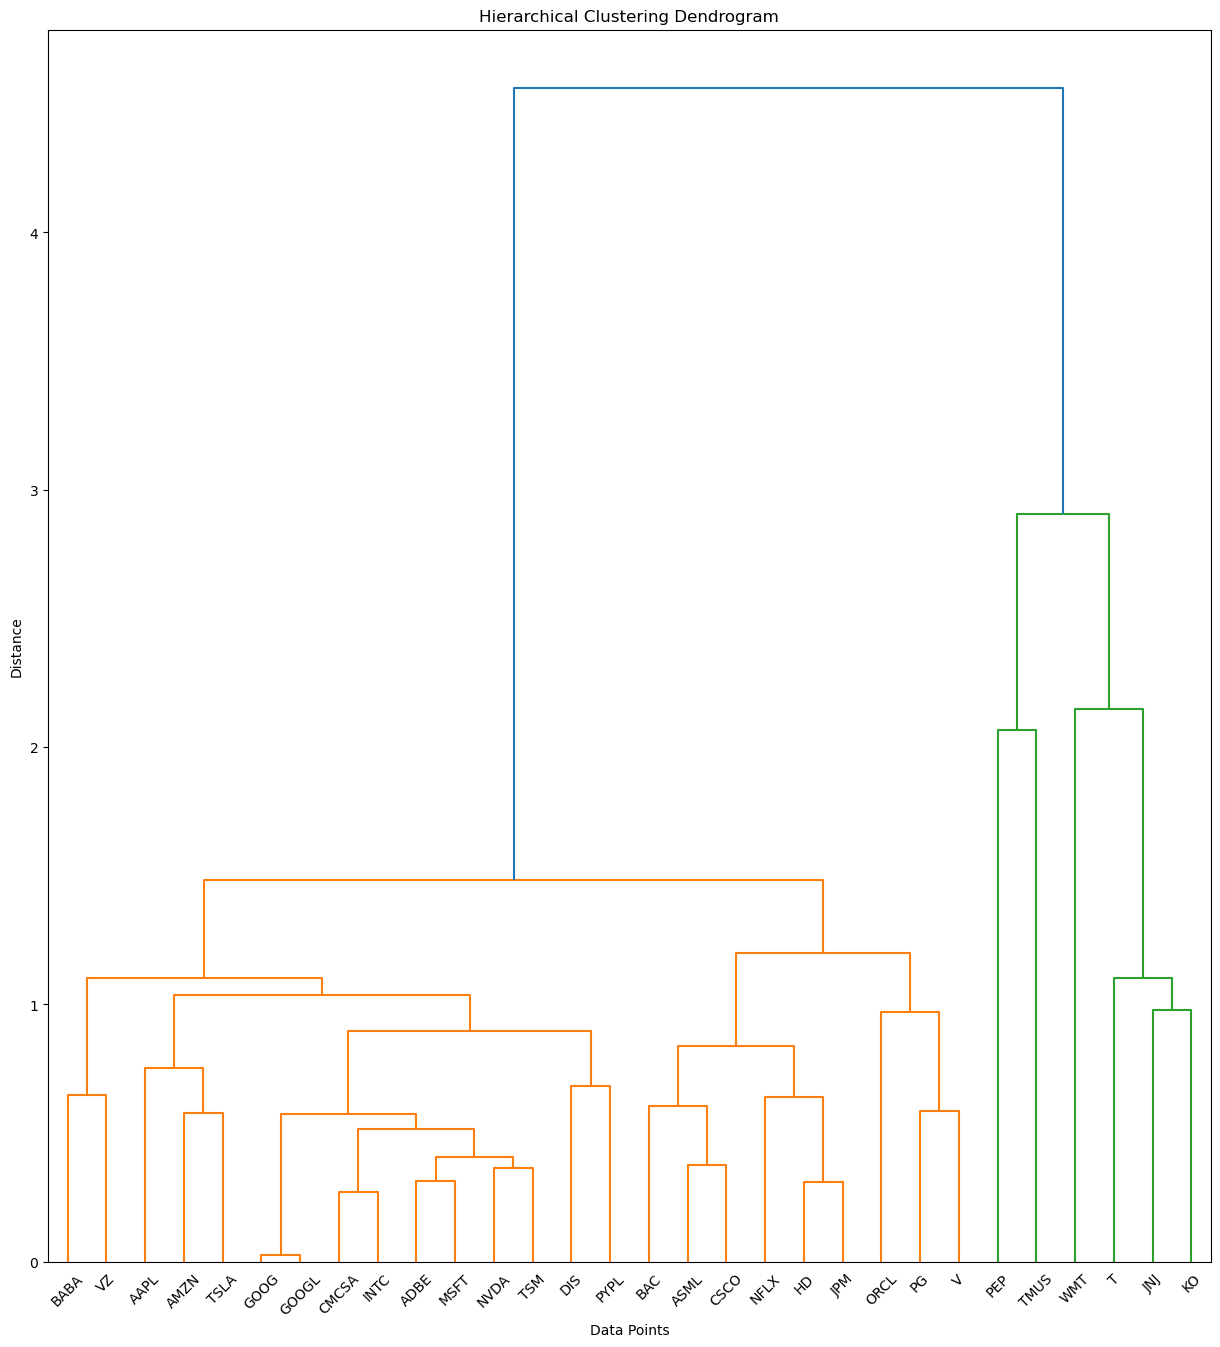

In [106]:


def create_dendrogram(data, method='average', metric='euclidean', figsize=(10, 6), orientation='top', labels=None):
    """
    Create a dendrogram using hierarchical clustering.

    Parameters:
    - data: 2D array-like or DataFrame
        The input data for clustering.
    - method: str, optional (default='average')
        The linkage algorithm to use. It could be 'single', 'complete', 'average', or others.
    - metric: str, optional (default='euclidean')
        The distance metric to use for clustering.
    - figsize: tuple, optional (default=(10, 6))
        The size of the figure.
    - orientation: str, optional (default='top')
        The orientation of the dendrogram. It could be 'top', 'right', 'bottom', or 'left'.
    - labels: list, optional (default=None)
        The labels for the data points.

    Returns:
    - None
        Displays the dendrogram.
    """
    # Perform hierarchical clustering
    linkage_matrix = linkage(data, method=method, metric=metric)

    # Create dendrogram
    plt.figure(figsize=figsize)
    dendrogram(linkage_matrix, labels=data.index, orientation=orientation)

    # Set plot parameters
   
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')

    # Show the plot
    plt.show()
    return linkage_matrix

# Example usage:
check = data.corr()
columns = check.columns
# Create dendrogram with default parameters
linkage_matrix = create_dendrogram(check, method='average', metric='euclidean', figsize=(15, 16), orientation='top', labels=None)


# 2.5

In [110]:


# Assuming you already have your linkage_matrix
linkage_matrix = linkage_matrix

# Set the number of clusters (you may need to adjust this based on your data)
num_clusters = 3

# Cut the dendrogram to form clusters
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Assign each stock to its respective cluster
stocks_by_cluster = {cluster: [] for cluster in set(clusters)}
for stock, cluster in zip(columns, clusters):
    stocks_by_cluster[cluster].append(stock)

# Display the stocks in each cluster
for cluster, stocks in stocks_by_cluster.items():
    print(f"Cluster {cluster}: {stocks}")


Cluster 1: ['AAPL', 'ADBE', 'AMZN', 'ASML', 'BABA', 'BAC', 'CMCSA', 'CSCO', 'DIS', 'GOOG', 'GOOGL', 'HD', 'INTC', 'JPM', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'PYPL', 'TSLA', 'TSM', 'V', 'VZ']
Cluster 2: ['PEP', 'TMUS']
Cluster 3: ['JNJ', 'KO', 'T', 'WMT']
